## Machine Learning to Predict Customer Default

This notebook sets out to predict whether or not customers will default by comparing 4 different classification algorithms: Random Forest, Support Vector Machines, Gradient Boost, and XGBoost. Goal is to achieve 80% or higher accuracy.

### Jennifer Brosnahan, MPH

In [1]:
# import libraries
# numpy, pandas, scipy, math, matplotlib
import numpy as np
import pandas as pd
import scipy
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

# helpers
%matplotlib inline
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

# estimators
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# model metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# visualizing Trees
import six
from six import StringIO
from IPython.display import Image
from sklearn import tree
from sklearn.tree import export_graphviz
import pydotplus
import os

### Reading dataset using Pandas

In [2]:
credit = pd.read_excel(r'C:\Users\jlbro\OneDrive\C2T3\credit.xlsx')
credit.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,age_4,age_6
0,20000,2,2,1,24,2,2,0,0,0,...,0,0,689,0,0,0,0,1,0,0
1,120000,2,2,2,26,0,2,0,0,0,...,3261,0,1000,1000,1000,0,2000,1,0,0
2,90000,2,2,2,34,0,0,0,0,0,...,15549,1518,1500,1000,1000,1000,5000,0,1,2
3,50000,2,2,1,37,0,0,0,0,0,...,29547,2000,2019,1200,1100,1069,1000,0,2,3
4,50000,1,2,1,57,0,0,0,0,0,...,19131,2000,36681,10000,9000,689,679,0,3,5


In [3]:
# examining structure
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29965 entries, 0 to 29964
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  29965 non-null  int64
 1   SEX        29965 non-null  int64
 2   EDUCATION  29965 non-null  int64
 3   MARRIAGE   29965 non-null  int64
 4   AGE        29965 non-null  int64
 5   PAY_1      29965 non-null  int64
 6   PAY_2      29965 non-null  int64
 7   PAY_3      29965 non-null  int64
 8   PAY_4      29965 non-null  int64
 9   PAY_5      29965 non-null  int64
 10  PAY_6      29965 non-null  int64
 11  BILL_AMT1  29965 non-null  int64
 12  BILL_AMT2  29965 non-null  int64
 13  BILL_AMT3  29965 non-null  int64
 14  BILL_AMT4  29965 non-null  int64
 15  BILL_AMT5  29965 non-null  int64
 16  BILL_AMT6  29965 non-null  int64
 17  PAY_AMT1   29965 non-null  int64
 18  PAY_AMT2   29965 non-null  int64
 19  PAY_AMT3   29965 non-null  int64
 20  PAY_AMT4   29965 non-null  int64
 21  PAY_AMT5   2

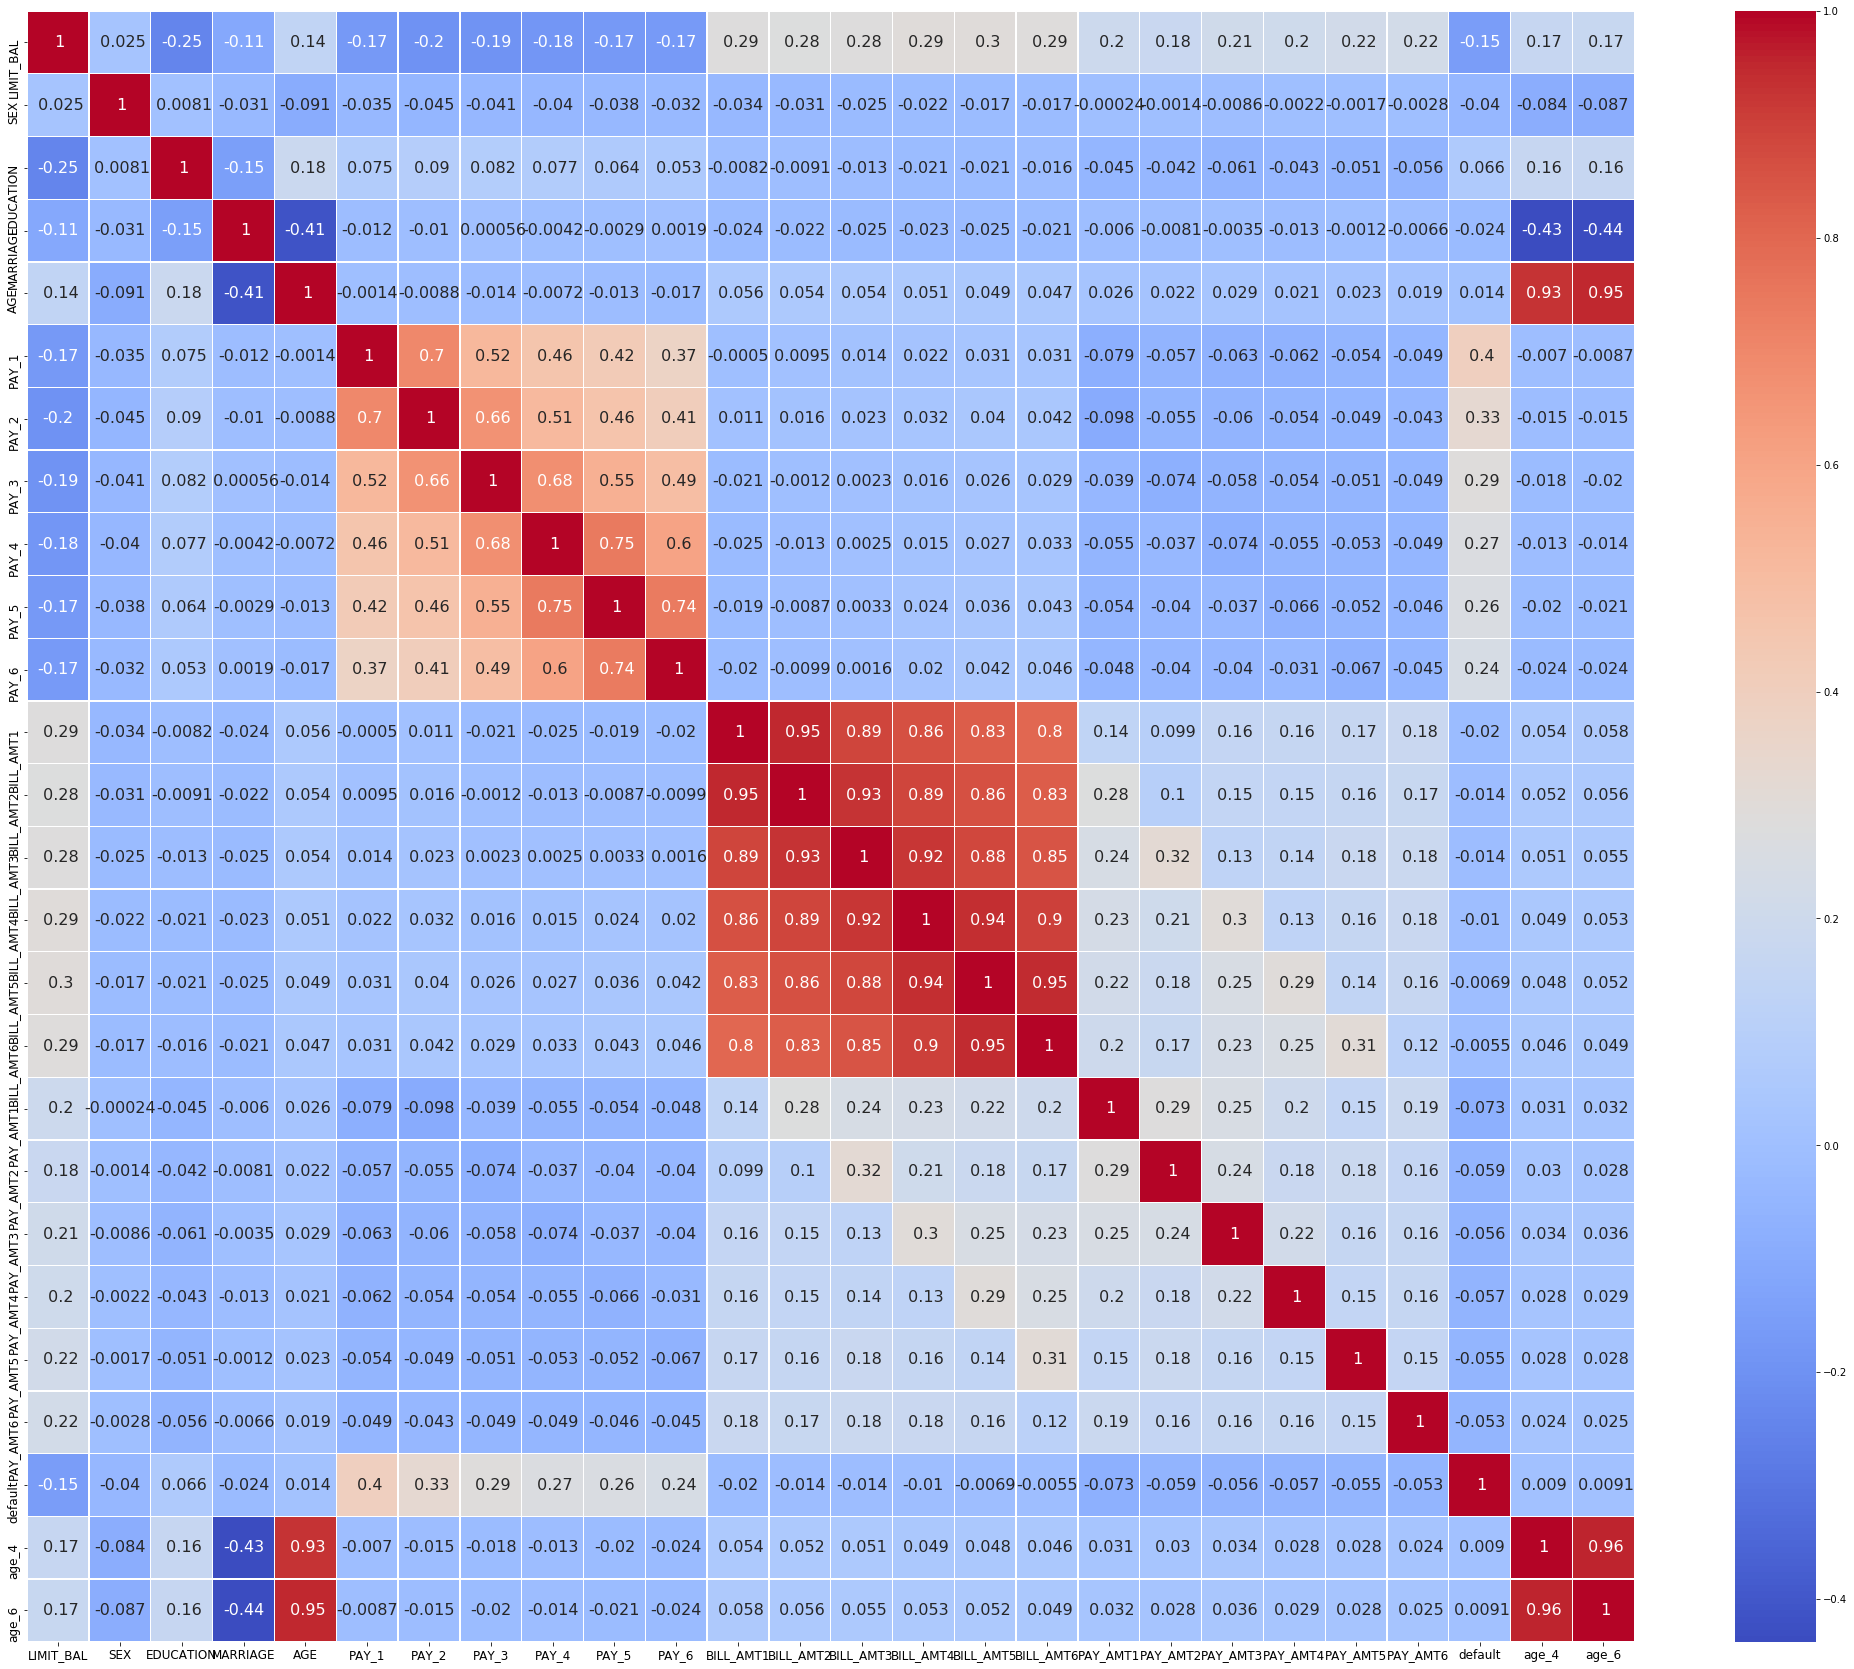

In [4]:
# checking correlation to default (target variable)
plt.subplots(figsize=(36,30))
ax = sns.heatmap(credit.corr(), annot = True, annot_kws={'size': 16}, cmap='coolwarm', fmt=' .2g', linewidths = .3)
ax.tick_params(labelsize = 12)

**Findings:** The only features correlated with default are Pay Status features. All other features have no correlation. Try predicting with Pay Status features only (feature selection). PCA may need to be utilized if Pay Statuses are ineffective in predicting default status.

In [5]:
# rearranging columns to place default (target variable) in front
cols_to_order = credit[['default']]

In [6]:
cols = ([col for col in cols_to_order if col in credit]
       + [col for col in credit if col not in cols_to_order])
credit = credit[cols]

In [7]:
credit.head()

,default,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,age_4,age_6
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,689,0,0,0,0,0,0
1,1,120000,2,2,2,26,0,2,0,0,...,3455,3261,0,1000,1000,1000,0,2000,0,0
2,0,90000,2,2,2,34,0,0,0,0,...,14948,15549,1518,1500,1000,1000,1000,5000,1,2
3,0,50000,2,2,1,37,0,0,0,0,...,28959,29547,2000,2019,1200,1100,1069,1000,2,3
4,0,50000,1,2,1,57,0,0,0,0,...,19146,19131,2000,36681,10000,9000,689,679,3,5


In [8]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29965 entries, 0 to 29964
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   default    29965 non-null  int64
 1   LIMIT_BAL  29965 non-null  int64
 2   SEX        29965 non-null  int64
 3   EDUCATION  29965 non-null  int64
 4   MARRIAGE   29965 non-null  int64
 5   AGE        29965 non-null  int64
 6   PAY_1      29965 non-null  int64
 7   PAY_2      29965 non-null  int64
 8   PAY_3      29965 non-null  int64
 9   PAY_4      29965 non-null  int64
 10  PAY_5      29965 non-null  int64
 11  PAY_6      29965 non-null  int64
 12  BILL_AMT1  29965 non-null  int64
 13  BILL_AMT2  29965 non-null  int64
 14  BILL_AMT3  29965 non-null  int64
 15  BILL_AMT4  29965 non-null  int64
 16  BILL_AMT5  29965 non-null  int64
 17  BILL_AMT6  29965 non-null  int64
 18  PAY_AMT1   29965 non-null  int64
 19  PAY_AMT2   29965 non-null  int64
 20  PAY_AMT3   29965 non-null  int64
 21  PAY_AMT4   2

#### Choosing a model

In [9]:
# features
X = credit[['PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']]

# target variable
y = credit['default']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)

In [10]:
X_train.head()

,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
16371,1,2,0,0,0,0
137,0,0,0,0,0,0
12713,0,0,0,0,0,0
10502,2,2,0,0,0,2
6675,1,2,0,0,0,0


In [11]:
y_train.head()

16371    0
137      0
12713    0
10502    1
6675     0
Name: default, dtype: int64

In [12]:
algos_Class = []
algos_Class.append(('Random Forest', RandomForestClassifier()))
algos_Class.append(('SVM', SVC()))
algos_Class.append(('Gradient Boosting', GradientBoostingClassifier()))
algos_Class.append(('XGBM', XGBClassifier()))

In [13]:
# classification
results = []
names = []
for name, model in algos_Class:
    result = cross_val_score(model, X, y, cv=3, scoring='accuracy')
    names.append(name)
    results.append(result)

In [14]:
for i in range(len(names)):
    print(names[i],results[i].mean())

Random Forest 0.8181214828234701
SVM 0.8195231347727727
Gradient Boosting 0.8201572089731224
XGBM 0.8192895043979694


**Findings:** Cross validation scores for all chosen algorithms achieve > 80% accuracy without tuning. Tuning will occur on top 3 models to optimize accuracy.

### Modeling: Random Forest Classification

In [15]:
# modeling
algo = RandomForestClassifier()

# parameters currently in use
pprint(algo.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [16]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': [2, 4, 5],
    'min_samples_split': [6, 9, 12]
}

In [17]:
CV_algo = GridSearchCV(estimator=algo, param_grid=param_grid, cv=3, n_jobs=-1)
CV_algo.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [18]:
# grid Search CV reveals best parameters to use for tuning model
CV_algo.best_params_

{'criterion': 'gini', 'min_samples_leaf': 5, 'min_samples_split': 9}

In [19]:
#Modeling
algo = RandomForestClassifier(criterion='gini', min_samples_leaf=5, min_samples_split=9, n_estimators=200)
model = algo.fit(X_train, y_train)

In [20]:
#Predictions
preds = model.predict(X_test)
#Assessment
print('Accuracy Score is: '), accuracy_score(y_test, preds)

Accuracy Score is: 


(None, 0.8186065136145222)

In [21]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      5804
           1       0.69      0.36      0.47      1688

    accuracy                           0.82      7492
   macro avg       0.76      0.66      0.68      7492
weighted avg       0.80      0.82      0.80      7492



**Random Forest top Accuracy Scores with tuning:** 81.9%

### Visualizing 1 tree in the forest

In [22]:
default_values = ['0','1']

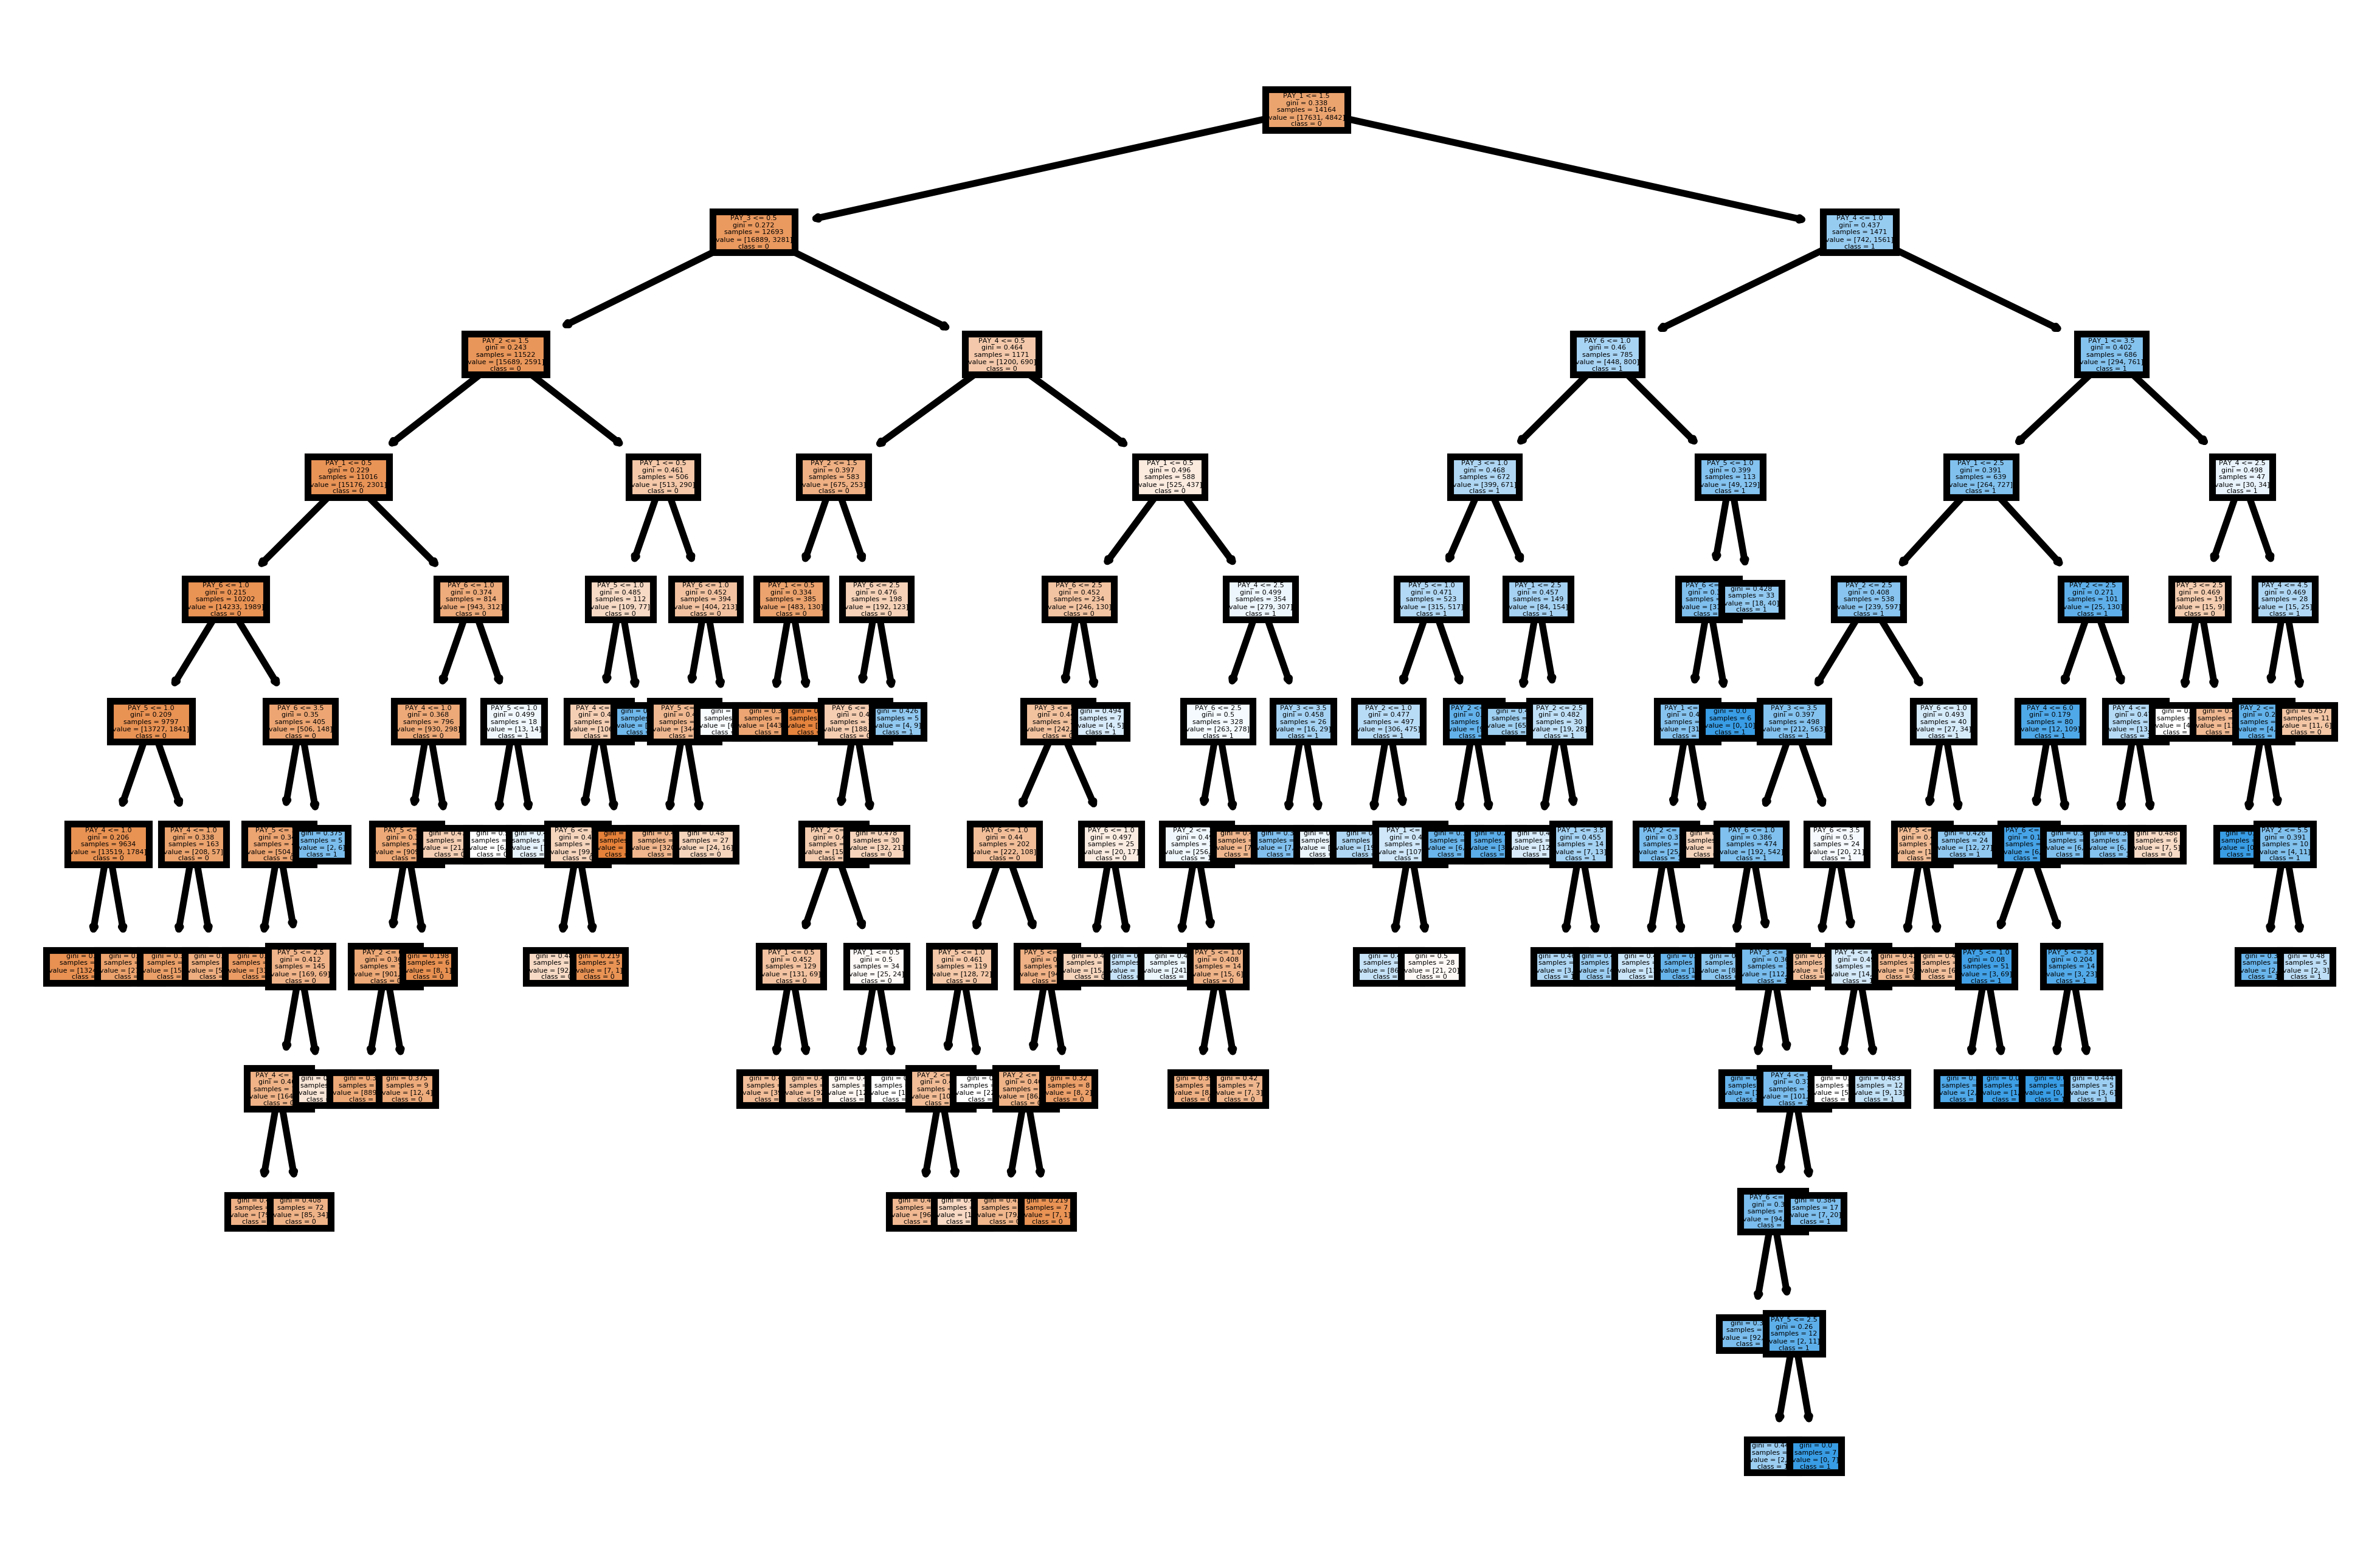

In [24]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (6,4), dpi=800)
tree.plot_tree(algo.estimators_[0],
               feature_names = X.columns, 
               class_names = default_values,
               filled = True);
fig.savefig('algo_individualtree.png')

### Modeling: Gradient Boosting Classifier

In [61]:
# features
X = credit[['PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']]

# target variable
y = credit['default']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)

In [62]:
X_train.head()

,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
16371,1,2,0,0,0,0
137,0,0,0,0,0,0
12713,0,0,0,0,0,0
10502,2,2,0,0,0,2
6675,1,2,0,0,0,0


In [63]:
y_train.head()

16371    0
137      0
12713    0
10502    1
6675     0
Name: default, dtype: int64

In [28]:
gbc = GradientBoostingClassifier()
# Parameters currently in use
pprint(gbc.get_params())

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


In [29]:
param_grid = {
    'max_features': [4, 5, 6],
    'max_depth': [2, 4, 5],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [4, 6, 8]
}

In [30]:
CV_algo = GridSearchCV(estimator=gbc, param_grid=param_grid, cv=3, n_jobs=-1)
CV_algo.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
         

In [31]:
# grid Search CV reveals best parameters to use for tuning model
CV_algo.best_params_

{'max_depth': 2,
 'max_features': 5,
 'min_samples_leaf': 3,
 'min_samples_split': 4}

In [64]:
# modeling, tuning hyperparameters
gbc = GradientBoostingClassifier(max_depth=2, max_features=5, min_samples_leaf=3, min_samples_split=4, n_estimators=50)
model = gbc.fit(X_train, y_train)

In [65]:
# predictions
preds = model.predict(X_test)
print('Accuracy on CV data: '), accuracy_score(y_test, preds)

Accuracy on CV data: 


(None, 0.8231446876668447)

In [66]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      5804
           1       0.70      0.38      0.49      1688

    accuracy                           0.82      7492
   macro avg       0.77      0.67      0.69      7492
weighted avg       0.81      0.82      0.80      7492



**Gradient Boosting top Accuracy Scores with tuning:** 82.2%

In [68]:
# confusion matrix shows where the errors are
cm = confusion_matrix(y_test, preds)
print(cm)

[[5530  274]
 [1051  637]]


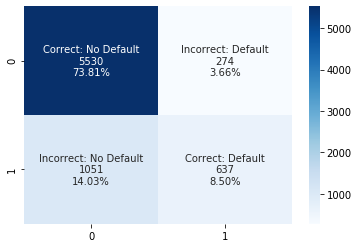

In [82]:
# heatmap of confusion matrix
group_names = ['Correct: No Default','Incorrect: Default','Incorrect: No Default','Correct: Default']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

### Analysis of Confusion Matrix:
1. **Correct, No Default:** Model correctly classifies Non-Default customers 84% of the time (5530/6581 = 84%)
2. **Correct, Default:** Model correctly classifies Default customers 70% of the time (637/911 = 70%)
3. **Incorrect, No Default:** Model incorrectly classifies Non-Default customers as Default 16% of the time (1051/6581 = 16%). Of all total predictions, this False Positive error occurs 3.66% of the time.
4. **Incorrect, Default:** Model incorrectly classifies Default customers as Non-Default 30% of the time (274/911 = 30%). Of all total predictions, this False Negative error occurs 14% of the time.

### Modeling: Xtreme Gradient Boosting Classifier

In [39]:
# features
X = credit[['PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']]

# target variable
y = credit['default']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)

In [40]:
X_train.head()

,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
16371,1,2,0,0,0,0
137,0,0,0,0,0,0
12713,0,0,0,0,0,0
10502,2,2,0,0,0,2
6675,1,2,0,0,0,0


In [41]:
y_train.head()

16371    0
137      0
12713    0
10502    1
6675     0
Name: default, dtype: int64

In [42]:
xgbc = XGBClassifier()
# Parameters currently in use
pprint(gbc.get_params())

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 2,
 'max_features': 5,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 3,
 'min_samples_split': 4,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


In [43]:
param_grid = {
    'max_features': [3, 4, 6],
    'max_depth': [2, 4, 5],
    'min_samples_leaf': [1, 3, 5],
}

In [44]:
CV_algo = GridSearchCV(estimator=xgbc, param_grid=param_grid, cv=3, n_jobs=-1)
CV_algo.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=Non

In [45]:
# grid Search CV reveals best parameters to use for tuning model
CV_algo.best_params_

{'max_depth': 2, 'max_features': 3, 'min_samples_leaf': 1}

In [56]:
# modeling, tuning hyperparameters
xgbc = XGBClassifier(n_estimators=400, max_depth=2, max_features=3, min_samples_leaf=1)
model = xgbc.fit(X_train, y_train)

In [57]:
# predictions
preds = model.predict(X_test)
print('Accuracy on CV data: '), accuracy_score(y_test, preds)

Accuracy on CV data: 


(None, 0.8215429791777896)

In [58]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      5804
           1       0.70      0.37      0.48      1688

    accuracy                           0.82      7492
   macro avg       0.77      0.66      0.69      7492
weighted avg       0.81      0.82      0.80      7492



In [60]:
# confusion matrix shows where the errors are: more errors are made predicting 'Default' as 'Non-default' (274/625=44%)
confusion_matrix(y_test, preds)

array([[5530,  274],
       [1063,  625]], dtype=int64)

**Xtreme Gradient Boosting top Accuracy Scores with tuning:** 82.2%

### Top Accuracy Score to predict customer default: 82.2% (Gradient Boosting Classifier)

### Conclusion:
This notebook set out to try to predict default status using variety of Classification models. Feature selection was utilized along with hyperparameter tuning on each algorithm for the top 3 algorithms. The following observations were made:
1. Gradient Boosting Classifier and XGBoost were top at 82.2%
2. Repayment Status for 6 prior months are used to predict default status.
4. The model makes more errors misclassifying those who will 'default' as 'non-default' (282/911 = 30% error rate) than it does misclassifying those who will 'not default' as 'default' (1050/6581 = 16%).
5. The model correctly classifies non-default customers 84% of the time, and default customers 70% of the time, both of which are better than an educated guess.